In [1]:
import pandas as pd 
import torch
import nltk
import einops
import numpy as np
import keras.utils as ku 
device = "cuda" if torch.cuda.is_available() else "cpu"

from datasets import load_dataset
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...


In [2]:
tokenizer = nltk.WordPunctTokenizer()
lemmatizer = nltk.WordNetLemmatizer()

In [3]:
df = pd.read_csv('/kaggle/input/shakespeare-nlp-analysis-data-engineering/shakespeare_plays.csv')

In [4]:
all_text = []
for sentence in df['text']:
    all_text.append(sentence.lower())

In [5]:
def tokenize_pipeline(sentence):
    tokens= tokenizer.tokenize(sentence)
    return [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]

In [6]:
all_tokenized_text = ([tokenize_pipeline(sentence) for sentence in all_text])
all_tokenized_words = set(word for sentence in all_tokenized_text for word in sentence)

In [7]:
len(all_tokenized_words)

19568

In [8]:
words_to_ids = {word: idx + 4 for idx, word in enumerate(all_tokenized_words)}

In [9]:
len(words_to_ids) 

19568

In [10]:
max_sequence_len = max([len(x) for x in all_tokenized_text])
max_sequence_len

17

In [11]:
from datasets import Dataset
dataset = {'Text': all_tokenized_text}
dataset = Dataset.from_dict(dataset)
dataset = dataset.train_test_split(test_size=0.05)
train_dataset, validation_dataset = dataset['train'],dataset['test']


In [12]:
class ShakespeareDataset(torch.utils.data.Dataset):
    def __init__(self, words_to_ids, dataset, max_len=19):
        self.words_to_ids = words_to_ids


        def convert_words_to_ids(example):
            return {'ids': [self.words_to_ids[token] for token in example['Text']]}
            
        self.dataset = dataset.map(convert_words_to_ids)
        self.max_len=max_len
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        examplede = self.dataset[index]
        examplede = examplede['ids']
        sentence = [1] + examplede+ [2]
        if len(sentence)< self.max_len:
            sentence +=[0 for _ in range(self.max_len-len(sentence))] 

        return torch.tensor(sentence)

In [13]:
train_dataset = ShakespeareDataset(words_to_ids,train_dataset)
validation_dataset = ShakespeareDataset(words_to_ids,validation_dataset)


Map:   0%|          | 0/102688 [00:00<?, ? examples/s]

Map:   0%|          | 0/5405 [00:00<?, ? examples/s]

In [14]:
validation_dataset[15].shape

torch.Size([19])

In [15]:
def collate_fn(item):
    x = torch.stack([i for i in item])
    return x

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size = 1024, collate_fn=collate_fn)
valid_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size = 1024, collate_fn=collate_fn)

In [17]:
next(iter(train_dataloader))

tensor([[    1,  5138, 11486,  ...,     0,     0,     0],
        [    1,  8148, 18263,  ...,     0,     0,     0],
        [    1,  7249,  2632,  ...,     0,     0,     0],
        ...,
        [    1,  4999, 19556,  ...,     0,     0,     0],
        [    1,  3447, 13172,  ...,     0,     0,     0],
        [    1,  7139,  7416,  ...,     0,     0,     0]])

In [59]:
class LSTMModel(torch.nn.Module):
    def __init__(self, dictionary_size, hidden_dim, layer_dim,max_seq_len):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = torch.nn.Dropout(0.3)
        self.embedding = torch.nn.Embedding(dictionary_size,hidden_dim)
        self.lstm = torch.nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim,num_layers=layer_dim, batch_first=True)
        self.lin = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, dictionary_size)

    def forward(self, x):
        emb = self.embedding(x)
        out, (hn, cn) = self.lstm(emb)
        out = self.lin(self.dropout(out))
        predicted = self.fc(self.dropout(out)) 
        return predicted

In [60]:
dictionary_size = len(words_to_ids)+4
hidden_dim = 200
layer_dim = 3
max_seq_len=19
model = LSTMModel(dictionary_size, hidden_dim, layer_dim,max_seq_len)
from functools import reduce

def get_num_of_params(
    model : torch.nn.Module
) -> int:
    return sum([reduce(lambda x, y: x * y, cur.shape) for cur in model.parameters()])

get_num_of_params(model)

8853372

In [61]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [62]:
torch.cuda.empty_cache()

In [63]:
from tqdm.auto import tqdm
train_loss =[]
valid_loss =[]
epochs = 30
for epoch in tqdm(range(epochs)):
    train_loss_current = []
    model.train()
    for idx, X in tqdm(enumerate(train_dataloader)):
        preds = model(X[:,:-1].to(device))
        loss = criterion(
        preds.view(-1, dictionary_size), X[:,1:].to(device).contiguous().view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        train_loss_current.append(loss.item())

    train_loss.append(np.mean(train_loss_current))
    
    valid_loss_current = []
    model.eval()
    with torch.inference_mode():
        for idx, X in enumerate(valid_dataloader):
            preds = model(X[:,:-1].to(device))
            loss = criterion(
                preds.view(-1, dictionary_size), 
                X[:,1:].to(device).contiguous().view(-1)
            )  
            valid_loss_current.append(loss.item())
    valid_loss.append(np.mean(valid_loss_current))
    
    print(f'Эпоха - {epoch+1}, train_loss - {train_loss[-1]}, valid_loss - {valid_loss[-1]}')

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Эпоха - 1, train_loss - 3.8955338780242617, valid_loss - 2.979619344075521


0it [00:00, ?it/s]

Эпоха - 2, train_loss - 2.978933206879266, valid_loss - 2.8929391304651895


0it [00:00, ?it/s]

Эпоха - 3, train_loss - 2.904642029563979, valid_loss - 2.8403162558873496


0it [00:00, ?it/s]

Эпоха - 4, train_loss - 2.8541864333766522, valid_loss - 2.807902971903483


0it [00:00, ?it/s]

Эпоха - 5, train_loss - 2.8144629898637827, valid_loss - 2.774641235669454


0it [00:00, ?it/s]

Эпоха - 6, train_loss - 2.7754507442512133, valid_loss - 2.7399791876475015


0it [00:00, ?it/s]

Эпоха - 7, train_loss - 2.7334150111321174, valid_loss - 2.697544972101847


0it [00:00, ?it/s]

Эпоха - 8, train_loss - 2.684647977942287, valid_loss - 2.659695863723755


0it [00:00, ?it/s]

Эпоха - 9, train_loss - 2.647278053925769, valid_loss - 2.636272350947062


0it [00:00, ?it/s]

Эпоха - 10, train_loss - 2.618359948148822, valid_loss - 2.6287409464518228


0it [00:00, ?it/s]

Эпоха - 11, train_loss - 2.592278978612163, valid_loss - 2.6115187803904214


0it [00:00, ?it/s]

Эпоха - 12, train_loss - 2.567531118298521, valid_loss - 2.598864754041036


0it [00:00, ?it/s]

Эпоха - 13, train_loss - 2.5459734661744373, valid_loss - 2.592079480489095


0it [00:00, ?it/s]

Эпоха - 14, train_loss - 2.526660199212556, valid_loss - 2.5844934781392417


0it [00:00, ?it/s]

Эпоха - 15, train_loss - 2.505093258206207, valid_loss - 2.5820698738098145


0it [00:00, ?it/s]

Эпоха - 16, train_loss - 2.4847734729842386, valid_loss - 2.5778122742970786


0it [00:00, ?it/s]

Эпоха - 17, train_loss - 2.4656073527761024, valid_loss - 2.577970584233602


0it [00:00, ?it/s]

Эпоха - 18, train_loss - 2.447481098741588, valid_loss - 2.579000989596049


0it [00:00, ?it/s]

Эпоха - 19, train_loss - 2.430084327659985, valid_loss - 2.5809207757314048


0it [00:00, ?it/s]

Эпоха - 20, train_loss - 2.4129076546961716, valid_loss - 2.584416468938192


0it [00:00, ?it/s]

Эпоха - 21, train_loss - 2.39690634991863, valid_loss - 2.5887444814046225


0it [00:00, ?it/s]

Эпоха - 22, train_loss - 2.3858343067735728, valid_loss - 2.588997761408488


0it [00:00, ?it/s]

Эпоха - 23, train_loss - 2.3730382942917325, valid_loss - 2.5901541709899902


0it [00:00, ?it/s]

Эпоха - 24, train_loss - 2.357017949075982, valid_loss - 2.596253991127014


0it [00:00, ?it/s]

Эпоха - 25, train_loss - 2.3401612362059034, valid_loss - 2.606495420138041


0it [00:00, ?it/s]

Эпоха - 26, train_loss - 2.3265003331817025, valid_loss - 2.6103318134943643


0it [00:00, ?it/s]

Эпоха - 27, train_loss - 2.316262148394443, valid_loss - 2.612912734349569


0it [00:00, ?it/s]

Эпоха - 28, train_loss - 2.303518004936747, valid_loss - 2.635569373766581


0it [00:00, ?it/s]

Эпоха - 29, train_loss - 2.2861573707939375, valid_loss - 2.6476813157399497


0it [00:00, ?it/s]

Эпоха - 30, train_loss - 2.269701820788997, valid_loss - 2.651711901028951


In [33]:
f= '/kaggle/working/Shakespear.model'
torch.save(model.state_dict(), f)

In [22]:
model.load_state_dict(torch.load('/kaggle/input/shakeword/pytorch/default/1/Shakespear.model', weights_only=True,map_location=torch.device('cpu')))
model.eval()

LSTMModel(
  (dropout): Dropout(p=0.2, inplace=False)
  (embedding): Embedding(19572, 200)
  (lstm): LSTM(200, 200, num_layers=3, batch_first=True)
  (fc): Linear(in_features=200, out_features=19572, bias=True)
)

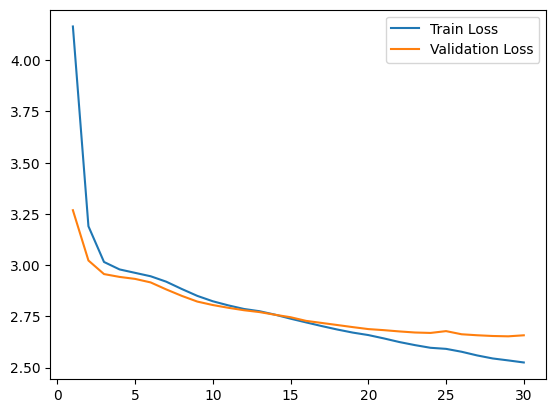

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


tr = {i+1:v for i,v in enumerate(train_loss)}
val = {i+1:v for i,v in enumerate(valid_loss)}

sns.lineplot(data=tr, label=str('Train Loss'))
sns.lineplot(data=val, label=str('Validation Loss'))
plt.legend()
plt.show()

In [44]:
model.eval()

LSTMModel(
  (dropout): Dropout(p=0.3, inplace=False)
  (embedding): Embedding(19572, 250)
  (lstm): LSTM(250, 250, num_layers=4, batch_first=True)
  (fc): Linear(in_features=250, out_features=19572, bias=True)
)

In [36]:
def dec(tokens:list,dictionary:dict):
    decoded = []
    for i in tokens: 
        key = next((key for key, value in dictionary.items() if value == i), None)
        decoded.append(key)
    return decoded 

In [37]:
MAX_SEQ_LEN = 18
temp=1
@torch.inference_mode
def generate(tokens) -> torch.Tensor:
    while len(tokens) < MAX_SEQ_LEN and tokens[-1]!=2:
        tokens.append(torch.softmax(model(torch.tensor(tokens).unsqueeze(0).to(device))/temp,-1)[0][-1].argmax().item())
        
    return tokens

In [38]:
def predi(sentence):
    final = [1]
    sentence = tokenize_pipeline(sentence.lower())
    try:
        for i in range(len(sentence)):
            final += [words_to_ids[sentence[i]]]
        example = generate(final)
        return ' '.join(dec(example,words_to_ids)[1:-1])
    except:
        print('Одного из слов в предложении Шекспир не знал...')
    

In [129]:
print(predi('Young and'))


young and the king s death


In [48]:
MAX_SEQ_LEN = 18
@torch.inference_mode
def generation(tokens) -> torch.Tensor:
    while len(tokens) < MAX_SEQ_LEN and tokens[-1]!=2:
        preds = model(torch.tensor(tokens).unsqueeze(0).to(device))
        preds_beam = beam_search(preds.to(device),6)[0][2]
        last = preds_beam[-1]
        tokens.append(last)
    return tokens

In [49]:
def beam_search(prediction, k=6):
    batch_size, seq_length, vocab_size = prediction.shape
    log_prob, indices = prediction[:, 0, :].topk(k, sorted=True)
    indices = indices.unsqueeze(-1).to(device)
    for n1 in range(1, seq_length):
        log_prob_temp = log_prob.unsqueeze(-1) + prediction[:, n1, :].unsqueeze(1).repeat(1, k, 1)
        log_prob, index_temp = log_prob_temp.view(batch_size, -1).topk(k, sorted=True)
        idx_begin = index_temp // vocab_size  
        idx_concat = index_temp % vocab_size 
        new_indices = torch.zeros((batch_size, k, n1+1), dtype=torch.int64).to(device)
        for n2 in range(batch_size):
            new_indices[n2, :, :-1] = indices[n2][idx_begin[n2]]
            new_indices[n2, :, -1] = idx_concat[n2]
        indices = new_indices
    return indices

In [50]:
def predictwithbeamsearch(sentence):
    final = [1]
    sentence = tokenize_pipeline(sentence.lower())
    try:
        for i in range(len(sentence)):
            final += [words_to_ids[sentence[i]]]
        example = generation(final)
        return ' '.join(dec(example,words_to_ids)[1:-1])
    except:
        print('Такого слова Шекспир не знал...')


In [52]:
print(predictwithbeamsearch('forever'))
print(predictwithbeamsearch('love'))
print(predictwithbeamsearch('to be or not'))
print(predictwithbeamsearch('hi'))
print(predictwithbeamsearch('leave the'))
print(predictwithbeamsearch('poor child'))

forever
love you i have not not a man
to be or not a man
hi i will be a man
leave the king of the world
poor child is a man
